In [23]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
from fastcore.utils import load_pickle

plt.style.use(["science", "nature"])

colors = ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"]


In [24]:
all_runs = glob("results/polymer_classification/*polymers*.pkl")


In [25]:
def compile_data(file):
    res = load_pickle(file)
    model_type = res["model_type"]
    train_size = res["train_size"]
    prefix = res["prefix"]
    acc = res["cm"].ACC_Macro
    f1_macro = res["cm"].F1_Macro
    f1_micro = res["cm"].F1_Micro

    return {
        "model_type": model_type,
        "train_size": train_size,
        "prefix": prefix,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }


In [26]:
all_results = [compile_data(run) for run in all_runs]


In [27]:
all_results = pd.DataFrame(all_results)


In [28]:
aggregated = all_results.groupby(["model_type", "prefix", "train_size"]).agg(
    ["mean", "std"]
)


In [29]:
all_results["prefix"].unique()


array(['', "I'm an expert polymer chemist "], dtype=object)

In [30]:
aggregated.loc["ada"].loc[""].index


Int64Index([10, 50, 100, 200, 500, 1000, 2000], dtype='int64', name='train_size')

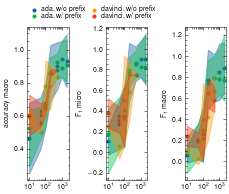

In [31]:
fig, ax = plt.subplots(1, 3, sharex="all")


ada_no_prefix = aggregated.loc["ada"].loc[""]
ada_prefix = aggregated.loc["ada"].loc["I'm an expert polymer chemist "]

davinci_no_prefix = aggregated.loc["davinci"].loc[""]
davinci_prefix = aggregated.loc["davinci"].loc["I'm an expert polymer chemist "]

alpha = 0.4

for i, metric in enumerate(["acc", "f1_micro", "f1_macro"]):
    ax[i].scatter(
        ada_no_prefix.index,
        ada_no_prefix[metric]["mean"],
        label="ada, w/o prefix" if i == 0 else None,
        c=colors[0],
    )
    ax[i].scatter(
        ada_prefix.index,
        ada_prefix[metric]["mean"],
        label="ada, w/ prefix" if i == 0 else None,
        c=colors[1],
    )
    ax[i].scatter(
        davinci_no_prefix.index,
        davinci_no_prefix[metric]["mean"],
        label="davinci, w/o prefix" if i == 0 else None,
        c=colors[2],
    )
    ax[i].scatter(
        davinci_prefix.index,
        davinci_prefix[metric]["mean"],
        label="davinci, w/ prefix" if i == 0 else None,
        c=colors[3],
    )

    ax[i].fill_between(
        ada_no_prefix.index,
        ada_no_prefix[metric]["mean"] - ada_no_prefix[metric]["std"],
        ada_no_prefix[metric]["mean"] + ada_no_prefix[metric]["std"],
        color=colors[0],
        alpha=alpha,
        interpolate=True,
    )
    ax[i].fill_between(
        ada_prefix.index,
        ada_no_prefix[metric]["mean"] - ada_prefix[metric]["std"],
        ada_no_prefix[metric]["mean"] + ada_prefix[metric]["std"],
        color=colors[1],
        alpha=alpha,
        interpolate=True,
    )
    ax[i].fill_between(
        davinci_no_prefix.index,
        davinci_no_prefix[metric]["mean"] - davinci_no_prefix[metric]["std"],
        davinci_no_prefix[metric]["mean"] + davinci_no_prefix[metric]["std"],
        color=colors[2],
        alpha=alpha,
        interpolate=True,
    )
    ax[i].fill_between(
        davinci_prefix.index,
        davinci_prefix[metric]["mean"] - davinci_prefix[metric]["std"],
        davinci_prefix[metric]["mean"] + davinci_prefix[metric]["std"],
        color=colors[3],
        alpha=alpha,
        interpolate=True,
    )


ax[0].set_ylabel("accuracy macro")
ax[1].set_ylabel(r"F$_1$ micro")
ax[2].set_ylabel(r"F$_1$ macro")

fig.legend(
    bbox_to_anchor=(0.7, 1.1), ncol=2, handletextpad=0, labelspacing=0, columnspacing=0
)
ax[0].set_xscale("log")
fig.tight_layout()
fig.savefig("polymer_learning_curve.pdf", bbox_inches=False)


Some conclusions:

- Using the bigger model (`davinci`) perhaps better in very low data regime. For more data, there is really no point in using it.
- Adding the prefix did not really help.
- We had relatively larger and non-smooth errorbands because I mistakenly used only 40 rows for evaluation.


Let's re-evaluate with more points.


In [48]:
# got this by querying the https://api.openai.com/v1/fine-tunes endpoint.
# it is a bit messy as I ran with multiple accounts ...
train_names_models_lsmo_account = {
    "run_files/2022-08-17-20-10-17_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-18-00-13-00",
    "run_files/2022-08-17-20-19-20_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-18-00-22-15",
    "run_files/2022-08-17-20-24-44_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-18-00-25-38",
    "run_files/2022-08-17-20-25-23_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-18-00-26-28",
    "run_files/2022-08-17-20-27-40_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-18-00-28-42",
    "run_files/2022-08-17-20-41-32_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-18-00-44-22",
    "run_files/2022-08-18-06-12-19_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-18-10-15-08",
    "run_files/2022-08-18-07-23-57_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-19-02-11-53",
    "run_files/2022-08-19-08-19-24_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-12-20-20",
    "run_files/2022-08-19-08-23-12_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-12-24-38",
    "run_files/2022-08-19-08-26-50_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-12-27-41",
    "run_files/2022-08-19-08-36-29_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-12-37-22",
    "run_files/2022-08-19-08-40-04_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-12-41-01",
    "run_files/2022-08-19-13-03-54_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-17-07-57",
    "run_files/2022-08-19-14-33-02_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-18-34-43",
    "run_files/2022-08-19-14-41-37_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-18-44-08",
    "run_files/2022-08-19-14-46-02_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-18-49-13",
    "run_files/2022-08-19-14-57-31_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-18-59-20",
    "run_files/2022-08-19-15-02-03_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-03-01",
    "run_files/2022-08-19-15-04-59_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-05-52",
    "run_files/2022-08-19-15-06-16_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-07-09",
    "run_files/2022-08-19-15-07-33_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-09-18",
    "run_files/2022-08-19-15-08-21_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-10-07",
    "run_files/2022-08-19-15-10-57_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-11-47",
    "run_files/2022-08-19-15-14-03_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-14-57",
    "run_files/2022-08-19-15-21-03_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-21-59",
    "run_files/2022-08-19-15-24-26_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-25-20",
    "run_files/2022-08-19-15-29-50_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-30-42",
    "run_files/2022-08-19-15-32-51_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-33-46",
    "run_files/2022-08-19-15-36-11_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-37-27",
    "run_files/2022-08-19-15-38-44_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-39-38",
    "run_files/2022-08-19-15-41-21_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-42-15",
    "run_files/2022-08-19-15-46-23_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-47-21",
    "run_files/2022-08-19-15-48-10_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-49-07",
    "run_files/2022-08-19-15-50-27_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-51-22",
    "run_files/2022-08-19-15-53-32_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-54-28",
    "run_files/2022-08-19-15-55-06_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-56-03",
    "run_files/2022-08-19-15-56-33_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-57-25",
    "run_files/2022-08-19-15-58-32_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-19-59-29",
    "run_files/2022-08-19-16-00-01_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-01-15",
    "run_files/2022-08-19-16-01-55_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-03-44",
    "run_files/2022-08-19-16-04-20_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-06-05",
    "run_files/2022-08-19-16-06-37_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-08-26",
    "run_files/2022-08-19-16-08-58_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-12-16",
    "run_files/2022-08-19-16-12-48_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-13-42",
    "run_files/2022-08-19-16-14-16_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-15-16",
    "run_files/2022-08-19-16-15-56_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-17-11",
    "run_files/2022-08-19-16-17-43_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-19-28",
    "run_files/2022-08-19-16-20-10_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-22-26",
    "run_files/2022-08-19-16-23-04_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-24-50",
    "run_files/2022-08-19-16-25-26_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-28-12",
    "run_files/2022-08-19-16-49-36_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-50-34",
    "run_files/2022-08-19-16-51-08_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-52-04",
    "run_files/2022-08-19-16-52-38_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-53-55",
    "run_files/2022-08-19-16-54-31_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-55-45",
    "run_files/2022-08-19-16-56-21_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-19-20-58-06",
    "run_files/2022-08-19-16-58-42_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-00-28",
    "run_files/2022-08-19-17-01-04_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-03-51",
    "run_files/2022-08-19-17-04-33_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-07-18",
    "run_files/2022-08-19-17-07-57_train_prompts_polymers_500.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-13-36",
    "run_files/2022-08-19-17-14-12_train_prompts_polymers_500.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-19-38",
    "run_files/2022-08-19-17-20-17_train_prompts_polymers_1000.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-32-38",
    "run_files/2022-08-19-17-33-16_train_prompts_polymers_1000.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-45-36",
    "run_files/2022-08-19-17-46-17_train_prompts_polymers_2000.jsonl": "ada:ft-lsmoepfl-2022-08-19-21-58-56",
    "run_files/2022-08-19-17-59-29_train_prompts_polymers_2000.jsonl": "ada:ft-lsmoepfl-2022-08-19-22-12-22",
    "run_files/2022-08-19-18-12-59_train_prompts_polymers_3000.jsonl": "ada:ft-lsmoepfl-2022-08-19-22-31-38",
    "run_files/2022-08-19-18-29-05_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-19-22-32-51",
    "run_files/2022-08-19-18-33-23_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-19-22-37-11",
    "run_files/2022-08-19-18-37-44_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-19-22-42-36",
    "run_files/2022-08-19-18-43-09_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-19-22-47-45",
    "run_files/2022-08-19-18-48-19_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-19-22-54-09",
    "run_files/2022-08-19-18-54-41_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-19-23-00-18",
    "run_files/2022-08-19-19-00-50_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-19-23-08-41",
    "run_files/2022-08-19-19-09-21_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-19-23-17-16",
    "run_files/2022-08-19-19-17-57_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-19-23-32-23",
    "run_files/2022-08-19-19-33-00_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-19-23-47-16",
    "run_files/2022-08-19-19-47-50_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-20-00-21-47",
    "run_files/2022-08-19-20-31-58_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-20-00-35-44",
    "run_files/2022-08-19-20-36-55_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-20-00-40-43",
    "run_files/2022-08-19-20-41-16_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-20-00-45-52",
    "run_files/2022-08-19-20-46-25_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-20-00-51-38",
    "run_files/2022-08-19-20-52-10_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-20-00-58-25",
    "run_files/2022-08-19-20-59-00_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-20-01-04-51",
    "run_files/2022-08-19-21-05-27_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-20-01-14-16",
    "run_files/2022-08-19-21-14-52_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-20-01-23-02",
    "run_files/2022-08-19-21-23-38_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-20-01-37-56",
    "run_files/2022-08-19-21-38-33_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-20-01-53-01",
    "run_files/2022-08-19-21-53-37_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-20-02-26-52",
    "run_files/2022-08-19-22-04-02_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-20-03-00-19",
    "run_files/2022-08-19-22-14-16_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-20-03-39-49",
    "run_files/2022-08-19-22-24-31_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-20-04-19-41",
    "run_files/2022-08-19-22-34-46_train_prompts_polymers_3000.jsonl": None,
    "run_files/2022-08-19-22-45-00_train_prompts_polymers_3000.jsonl": None,
    "run_files/2022-08-19-22-55-15_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-20-02-56-09",
    "run_files/2022-08-19-22-56-42_train_prompts_polymers_10.jsonl": "ada:ft-lsmoepfl-2022-08-20-02-57-40",
    "run_files/2022-08-19-22-58-11_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-20-02-59-29",
    "run_files/2022-08-19-23-00-08_train_prompts_polymers_50.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-01-19",
    "run_files/2022-08-19-23-01-56_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-03-42",
    "run_files/2022-08-19-23-04-13_train_prompts_polymers_100.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-05-59",
    "run_files/2022-08-19-23-06-30_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-09-14",
    "run_files/2022-08-19-23-09-45_train_prompts_polymers_200.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-12-29",
    "run_files/2022-08-19-23-13-00_train_prompts_polymers_500.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-18-28",
    "run_files/2022-08-19-23-19-00_train_prompts_polymers_500.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-24-37",
    "run_files/2022-08-19-23-25-09_train_prompts_polymers_1000.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-37-22",
    "run_files/2022-08-19-23-37-56_train_prompts_polymers_1000.jsonl": "ada:ft-lsmoepfl-2022-08-20-03-50-31",
    "run_files/2022-08-19-23-51-04_train_prompts_polymers_2000.jsonl": "ada:ft-lsmoepfl-2022-08-20-04-03-49",
    "run_files/2022-08-20-00-04-22_train_prompts_polymers_2000.jsonl": "ada:ft-lsmoepfl-2022-08-20-04-17-11",
    "run_files/2022-08-20-00-17-42_train_prompts_polymers_3000.jsonl": "ada:ft-lsmoepfl-2022-08-20-04-36-54",
    "run_files/2022-08-20-00-32-57_train_prompts_polymers_3000.jsonl": "ada:ft-lsmoepfl-2022-08-20-04-55-29",
    "run_files/2022-08-20-00-48-13_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-20-04-52-03",
    "run_files/2022-08-20-00-52-39_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-20-04-56-26",
    "run_files/2022-08-20-00-56-59_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-20-05-01-50",
    "run_files/2022-08-20-01-02-23_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-20-05-07-26",
    "run_files/2022-08-27-10-31-11_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-27-14-35-02",
    "run_files/2022-08-27-10-36-04_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-27-14-40-18",
    "run_files/2022-08-27-10-41-14_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-27-14-45-52",
    "run_files/2022-08-27-10-46-48_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-27-14-51-38",
    "run_files/2022-08-27-10-52-33_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-27-14-58-29",
    "run_files/2022-08-27-10-59-26_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-27-15-05-20",
    "run_files/2022-08-27-11-06-17_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-27-15-14-28",
    "run_files/2022-08-27-11-15-29_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-27-15-23-25",
    "run_files/2022-08-27-11-24-21_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-27-15-38-38",
    "run_files/2022-08-27-11-34-45_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-27-15-52-47",
    "run_files/2022-08-27-11-48-54_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-16-31-23",
    "run_files/2022-08-27-12-03-04_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-17-04-58",
    "run_files/2022-08-27-12-13-22_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-17-45-12",
    "run_files/2022-08-27-12-23-40_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-18-25-57",
    "run_files/2022-08-27-12-33-58_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-19-29-16",
    "run_files/2022-08-27-12-44-17_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-09-24",
    "run_files/2022-08-27-12-54-36_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-17-34",
    "run_files/2022-08-27-13-04-54_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-28-49",
    "run_files/2022-08-27-13-15-11_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-34-08",
    "run_files/2022-08-27-13-25-29_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-27-18-30-38",
    "run_files/2022-08-27-13-35-48_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-39-39",
    "run_files/2022-08-27-13-46-06_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-45-32",
    "run_files/2022-08-27-13-56-24_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-53-06",
    "run_files/2022-08-27-14-06-42_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-27-21-25-17",
    "run_files/2022-08-27-14-17-00_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-27-22-06-57",
    "run_files/2022-08-27-14-27-19_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-27-23-27-05",
    "run_files/2022-08-27-14-37-38_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-20-03-03",
    "run_files/2022-08-27-14-47-56_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-00-10-25",
    "run_files/2022-08-27-14-58-14_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-03-03-11",
    "run_files/2022-08-27-15-08-33_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-05-46-40",
    "run_files/2022-08-27-15-18-51_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-08-17-13",
    "run_files/2022-08-27-15-29-10_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-09-17-12",
    "run_files/2022-08-27-15-39-29_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-10-01-37",
    "run_files/2022-08-27-15-49-48_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-10-39-02",
    "run_files/2022-08-27-16-00-05_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-28-12-38-40",
    "run_files/2022-08-27-16-10-23_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-27-23-36-37",
    "run_files/2022-08-27-16-20-41_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-12-44-51",
    "run_files/2022-08-27-16-30-58_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-00-28-08",
    "run_files/2022-08-27-16-41-16_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-00-22-37",
    "run_files/2022-08-27-16-51-34_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-13-33-20",
    "run_files/2022-08-27-17-01-52_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-06-33-07",
    "run_files/2022-08-27-17-12-10_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-13-55-33",
    "run_files/2022-08-27-17-22-29_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-10-35-12",
    "run_files/2022-08-27-17-32-47_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-16-09-54",
    "run_files/2022-08-27-17-43-05_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-15-36-07",
    "run_files/2022-08-27-17-53-24_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-01-42-36",
    "run_files/2022-08-27-18-03-42_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-27-23-04-23",
    "run_files/2022-08-27-18-17-13_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-18-09-40",
    "run_files/2022-08-27-18-27-31_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-27-23-07-53",
    "run_files/2022-08-27-18-37-49_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-06-04-29",
    "run_files/2022-08-27-18-48-07_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-27-23-12-32",
    "run_files/2022-08-27-18-58-25_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-28-00-14-55",
    "run_files/2022-08-27-19-08-43_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-18-49-22",
    "run_files/2022-08-27-19-19-01_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-18-55-17",
    "run_files/2022-08-27-19-29-20_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-04-37",
    "run_files/2022-08-27-19-39-37_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-12-43",
    "run_files/2022-08-27-19-49-55_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-06-18-46",
    "run_files/2022-08-27-20-00-13_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-43-56",
    "run_files/2022-08-27-20-10-31_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-20-33-00",
    "run_files/2022-08-27-20-20-50_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-01-01-33",
    "run_files/2022-08-27-20-31-10_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-02-22-58",
    "run_files/2022-08-27-20-41-30_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-22-50-46",
    "run_files/2022-08-27-20-51-48_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-04-06-41",
    "run_files/2022-08-27-21-02-07_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-00-24-13",
    "run_files/2022-08-27-21-12-25_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-29-00-27-45",
    "run_files/2022-08-27-21-22-44_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-14-55-56",
    "run_files/2022-08-27-21-33-01_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-28-07-18-14",
    "run_files/2022-08-27-21-43-18_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-29-00-56-42",
    "run_files/2022-08-27-21-53-36_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-26-08",
    "run_files/2022-08-27-22-03-54_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-29-01-36-11",
    "run_files/2022-08-27-22-14-12_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-05-05-55",
    "run_files/2022-08-27-22-24-31_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-04-57-38",
    "run_files/2022-08-27-22-34-49_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-14-18-18",
    "run_files/2022-08-27-22-45-07_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-16-27-34",
    "run_files/2022-08-27-22-55-26_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-18-43-39",
    "run_files/2022-08-27-23-05-44_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-17-09-48",
    "run_files/2022-08-27-23-16-02_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-09-57-45",
    "run_files/2022-08-27-23-26-21_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-02-17-04",
    "run_files/2022-08-27-23-51-46_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-22-06-25",
    "run_files/2022-08-28-00-02-04_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-29-02-21-29",
    "run_files/2022-08-28-00-12-21_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-29-03-40-18",
    "run_files/2022-08-28-00-22-42_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-29-03-45-52",
    "run_files/2022-08-28-00-33-03_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-29-03-52-04",
    "run_files/2022-08-28-00-43-21_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-20-26",
    "run_files/2022-08-28-00-53-39_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-29-04-33-59",
    "run_files/2022-08-28-01-03-57_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-28-06-00-48",
    "run_files/2022-08-28-01-14-15_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-29-05-03-33",
    "run_files/2022-08-28-01-24-34_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-05-37-13",
    "run_files/2022-08-28-01-34-52_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-07-13-43",
    "run_files/2022-08-28-01-45-10_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-11-19-23",
    "run_files/2022-08-28-01-55-29_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-06-18-08",
    "run_files/2022-08-28-02-05-48_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-08-22-17",
    "run_files/2022-08-28-02-16-06_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-03-21-39",
    "run_files/2022-08-28-02-26-24_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-06-36-45",
    "run_files/2022-08-28-02-36-42_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-29-08-30-00",
    "run_files/2022-08-28-02-46-59_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-29-07-21-47",
    "run_files/2022-08-28-02-57-17_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-28-16-32-55",
    "run_files/2022-08-28-03-07-35_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-14-01-04",
    "run_files/2022-08-28-03-17-53_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-49-38",
    "run_files/2022-08-28-03-28-12_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-29-08-37-56",
    "run_files/2022-08-28-03-38-29_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-29-08-45-37",
    "run_files/2022-08-28-03-48-47_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-29-09-18-11",
    "run_files/2022-08-28-03-59-06_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-29-03-35-48",
    "run_files/2022-08-28-04-09-24_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-04-25-53",
    "run_files/2022-08-28-04-19-43_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-11-52-50",
    "run_files/2022-08-28-04-30-03_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-13-25-22",
    "run_files/2022-08-28-04-40-22_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-10-06-08",
    "run_files/2022-08-28-04-50-40_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-11-16-37",
    "run_files/2022-08-28-05-00-59_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-07-17-16",
    "run_files/2022-08-28-05-11-13_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-16-36-33",
    "run_files/2022-08-28-05-21-27_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-19-53-07",
    "run_files/2022-08-28-05-31-41_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-28-13-41-22",
    "run_files/2022-08-28-05-41-55_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-29-00-52-10",
    "run_files/2022-08-28-05-52-09_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-28-21-43-04",
    "run_files/2022-08-28-06-02-23_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-29-11-28-02",
    "run_files/2022-08-28-06-12-37_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-29-04-49-24",
    "run_files/2022-08-28-06-22-52_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-29-04-41-41",
    "run_files/2022-08-28-06-33-06_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-29-11-42-11",
    "run_files/2022-08-28-06-43-20_train_prompts_polymers_500.jsonl": "davinci:ft-lsmoepfl-2022-08-29-11-56-53",
    "run_files/2022-08-28-06-53-35_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-01-30-29",
    "run_files/2022-08-28-07-03-50_train_prompts_polymers_1000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-14-52-15",
    "run_files/2022-08-28-07-14-04_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-12-37-58",
    "run_files/2022-08-28-07-24-18_train_prompts_polymers_2000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-12-33-39",
    "run_files/2022-08-28-07-34-33_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-28-21-37-31",
    "run_files/2022-08-28-07-44-46_train_prompts_polymers_3000.jsonl": "davinci:ft-lsmoepfl-2022-08-29-13-38-00",
    "run_files/2022-08-28-07-55-01_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-28-16-13-35",
    "run_files/2022-08-28-08-05-15_train_prompts_polymers_10.jsonl": "davinci:ft-lsmoepfl-2022-08-29-08-26-09",
    "run_files/2022-08-28-08-15-30_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-28-21-47-34",
    "run_files/2022-08-28-08-25-44_train_prompts_polymers_50.jsonl": "davinci:ft-lsmoepfl-2022-08-29-13-55-05",
    "run_files/2022-08-28-08-35-58_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-29-14-01-20",
    "run_files/2022-08-28-08-46-13_train_prompts_polymers_100.jsonl": "davinci:ft-lsmoepfl-2022-08-29-11-22-10",
    "run_files/2022-08-28-08-56-28_train_prompts_polymers_200.jsonl": "davinci:ft-lsmoepfl-2022-08-29-14-09-15",
}


train_filenames_gmail = {
    "run_files/2022-08-22-13-13-25_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-22-18-14-27",
    "run_files/2022-08-22-13-15-07_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-22-18-16-05",
    "run_files/2022-08-22-13-16-40_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-22-18-18-57",
    "run_files/2022-08-22-13-19-34_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-22-18-20-51",
    "run_files/2022-08-22-13-21-28_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-22-18-23-13",
    "run_files/2022-08-22-13-24-19_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-22-18-26-06",
    "run_files/2022-08-22-13-26-47_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-22-18-29-29",
    "run_files/2022-08-22-13-30-05_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-22-18-32-50",
    "run_files/2022-08-22-13-33-25_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-22-18-39-00",
    "run_files/2022-08-22-13-39-38_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-22-18-45-06",
    "run_files/2022-08-22-14-03-22_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-22-19-15-41",
    "run_files/2022-08-22-14-16-20_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-22-19-28-30",
    "run_files/2022-08-22-14-29-09_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-22-19-42-11",
    "run_files/2022-08-22-14-42-58_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-22-19-55-37",
    "run_files/2022-08-22-14-54-36_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-22-20-14-14",
    "run_files/2022-08-22-17-02-10_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-22-22-03-07",
    "run_files/2022-08-22-18-31-35_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-22-23-32-53",
    "run_files/2022-08-22-18-33-53_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-22-23-35-13",
    "run_files/2022-08-22-18-36-24_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-22-23-38-15",
    "run_files/2022-08-22-18-39-14_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-22-23-41-04",
    "run_files/2022-08-22-18-42-18_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-22-23-45-04",
    "run_files/2022-08-22-19-14-01_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-00-16-50",
    "run_files/2022-08-22-19-17-30_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-00-22-59",
    "run_files/2022-08-22-19-23-39_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-00-29-05",
    "run_files/2022-08-22-19-29-45_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-00-42-55",
    "run_files/2022-08-22-19-47-04_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-00-59-18",
    "run_files/2022-08-22-20-00-22_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-01-13-01",
    "run_files/2022-08-22-20-14-07_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-01-27-04",
    "run_files/2022-08-22-20-28-14_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-01-46-57",
    "run_files/2022-08-22-20-43-32_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-02-05-19",
    "run_files/2022-08-22-21-01-53_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-02-06-06",
    "run_files/2022-08-22-21-07-11_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-02-08-11",
    "run_files/2022-08-22-21-09-14_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-02-10-30",
    "run_files/2022-08-22-21-11-33_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-02-12-50",
    "run_files/2022-08-22-21-13-49_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-02-15-43",
    "run_files/2022-08-22-21-16-44_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-02-18-30",
    "run_files/2022-08-22-21-19-36_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-02-25-00",
    "run_files/2022-08-22-21-26-02_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-02-28-58",
    "run_files/2022-08-22-21-30-01_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-02-35-33",
    "run_files/2022-08-22-21-36-37_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-02-42-18",
    "run_files/2022-08-22-21-43-22_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-02-55-54",
    "run_files/2022-08-22-21-57-00_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-03-09-23",
    "run_files/2022-08-22-22-10-31_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-03-23-58",
    "run_files/2022-08-22-22-24-59_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-03-37-52",
    "run_files/2022-08-22-22-38-56_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-03-57-32",
    "run_files/2022-08-22-22-44-17_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-04-16-16",
    "run_files/2022-08-22-22-54-35_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-04-17-04",
    "run_files/2022-08-22-23-04-53_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-04-17-50",
    "run_files/2022-08-22-23-15-11_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-04-18-56",
    "run_files/2022-08-22-23-20-00_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-04-21-15",
    "run_files/2022-08-22-23-22-16_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-04-24-02",
    "run_files/2022-08-22-23-25-05_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-04-26-56",
    "run_files/2022-08-22-23-27-57_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-04-30-43",
    "run_files/2022-08-22-23-31-45_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-04-34-33",
    "run_files/2022-08-22-23-35-38_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-04-41-05",
    "run_files/2022-08-22-23-42-09_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-04-47-42",
    "run_files/2022-08-22-23-48-54_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-05-01-13",
    "run_files/2022-08-23-00-02-16_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-05-14-38",
    "run_files/2022-08-23-00-15-41_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-05-28-22",
    "run_files/2022-08-23-00-29-27_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-05-42-17",
    "run_files/2022-08-23-00-43-21_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-06-02-10",
    "run_files/2022-08-23-00-58-40_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-06-20-34",
    "run_files/2022-08-23-01-17-06_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-06-21-23",
    "run_files/2022-08-23-01-22-26_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-06-23-22",
    "run_files/2022-08-23-01-24-22_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-06-26-08",
    "run_files/2022-08-23-01-27-09_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-06-28-27",
    "run_files/2022-08-23-01-29-26_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-06-31-13",
    "run_files/2022-08-23-01-32-14_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-06-34-02",
    "run_files/2022-08-23-01-35-07_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-06-37-56",
    "run_files/2022-08-23-01-38-58_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-06-41-43",
    "run_files/2022-08-23-01-42-45_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-06-48-13",
    "run_files/2022-08-23-01-49-19_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-06-54-49",
    "run_files/2022-08-23-01-55-52_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-07-08-29",
    "run_files/2022-08-23-02-09-39_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-07-22-02",
    "run_files/2022-08-23-02-23-05_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-07-35-55",
    "run_files/2022-08-23-02-37-31_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-07-50-24",
    "run_files/2022-08-23-02-51-30_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-08-10-20",
    "run_files/2022-08-23-03-01-52_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-08-29-03",
    "run_files/2022-08-23-03-12-10_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-08-29-48",
    "run_files/2022-08-23-03-22-27_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-08-30-37",
    "run_files/2022-08-23-03-32-44_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-08-33-59",
    "run_files/2022-08-23-03-35-03_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-08-36-42",
    "run_files/2022-08-23-03-37-46_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-08-39-38",
    "run_files/2022-08-23-03-40-40_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-08-42-27",
    "run_files/2022-08-23-03-43-29_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-08-46-16",
    "run_files/2022-08-23-03-47-19_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-08-50-05",
    "run_files/2022-08-23-03-51-06_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-08-56-44",
    "run_files/2022-08-23-03-57-50_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-09-03-22",
    "run_files/2022-08-23-04-04-27_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-09-17-02",
    "run_files/2022-08-23-04-18-09_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-09-30-34",
    "run_files/2022-08-23-04-31-37_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-09-44-31",
    "run_files/2022-08-23-04-45-35_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-09-58-18",
    "run_files/2022-08-23-04-59-23_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-10-18-11",
    "run_files/2022-08-23-05-09-53_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-10-36-36",
    "run_files/2022-08-23-05-20-11_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-10-37-24",
    "run_files/2022-08-23-05-30-29_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-10-38-38",
    "run_files/2022-08-23-05-40-47_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-10-42-14",
    "run_files/2022-08-23-05-43-16_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-10-45-00",
    "run_files/2022-08-23-05-46-00_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-10-47-44",
    "run_files/2022-08-23-05-49-09_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-10-50-53",
    "run_files/2022-08-23-05-52-26_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-10-55-14",
    "run_files/2022-08-23-05-56-17_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-10-59-09",
    "run_files/2022-08-23-06-00-13_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-11-05-49",
    "run_files/2022-08-23-06-06-51_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-11-12-31",
    "run_files/2022-08-23-06-13-38_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-11-26-00",
    "run_files/2022-08-23-06-27-06_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-11-40-04",
    "run_files/2022-08-23-06-41-09_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-11-53-59",
    "run_files/2022-08-23-06-55-02_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-12-07-54",
    "run_files/2022-08-23-07-09-05_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-12-28-03",
    "run_files/2022-08-23-07-24-24_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-12-46-46",
    "run_files/2022-08-23-07-43-04_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-12-47-32",
    "run_files/2022-08-23-07-48-38_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-12-49-37",
    "run_files/2022-08-23-07-50-40_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-12-52-00",
    "run_files/2022-08-23-07-53-01_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-12-54-26",
    "run_files/2022-08-23-07-55-31_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-12-57-15",
    "run_files/2022-08-23-07-58-22_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-13-00-22",
    "run_files/2022-08-23-08-01-26_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-13-04-17",
    "run_files/2022-08-23-08-05-30_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-13-08-22",
    "run_files/2022-08-23-08-09-28_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-13-15-39",
    "run_files/2022-08-23-08-16-56_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-13-22-32",
    "run_files/2022-08-23-08-23-40_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-13-37-02",
    "run_files/2022-08-23-08-40-11_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-13-52-35",
    "run_files/2022-08-23-09-04-28_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-14-17-22",
    "run_files/2022-08-23-09-19-15_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-14-39-11",
    "run_files/2022-08-23-09-29-41_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-14-57-34",
    "run_files/2022-08-23-09-40-02_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-14-58-20",
    "run_files/2022-08-23-09-50-22_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-14-59-04",
    "run_files/2022-08-23-10-00-44_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-15-02-04",
    "run_files/2022-08-23-10-04-58_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-15-06-22",
    "run_files/2022-08-23-10-07-41_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-15-09-35",
    "run_files/2022-08-23-10-11-07_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-15-12-53",
    "run_files/2022-08-23-10-14-13_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-15-17-01",
    "run_files/2022-08-23-10-18-21_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-15-21-09",
    "run_files/2022-08-23-10-22-15_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-15-27-47",
    "run_files/2022-08-23-10-28-52_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-15-34-35",
    "run_files/2022-08-23-10-35-42_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-15-48-04",
    "run_files/2022-08-23-11-33-57_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-16-46-16",
    "run_files/2022-08-23-11-47-27_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-17-00-10",
    "run_files/2022-08-23-12-00-51_train_prompts_polymers_2000.jsonl": "ada:ft-personal-2022-08-23-17-13-31",
    "run_files/2022-08-23-12-14-10_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-17-32-41",
    "run_files/2022-08-23-12-29-24_train_prompts_polymers_3000.jsonl": "ada:ft-personal-2022-08-23-17-54-43",
    "run_files/2022-08-23-12-42-55_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-17-55-29",
    "run_files/2022-08-23-12-53-09_train_prompts_polymers_10.jsonl": "ada:ft-personal-2022-08-23-17-56-17",
    "run_files/2022-08-23-14-34-25_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-19-35-39",
    "run_files/2022-08-23-14-36-45_train_prompts_polymers_50.jsonl": "ada:ft-personal-2022-08-23-19-38-00",
    "run_files/2022-08-23-14-38-35_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-19-40-20",
    "run_files/2022-08-23-14-40-54_train_prompts_polymers_100.jsonl": "ada:ft-personal-2022-08-23-19-42-37",
    "run_files/2022-08-23-14-43-12_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-19-46-00",
    "run_files/2022-08-23-14-46-34_train_prompts_polymers_200.jsonl": "ada:ft-personal-2022-08-23-19-49-20",
    "run_files/2022-08-23-14-49-54_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-19-55-19",
    "run_files/2022-08-23-14-55-55_train_prompts_polymers_500.jsonl": "ada:ft-personal-2022-08-23-20-01-20",
    "run_files/2022-08-23-15-01-58_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-20-14-20",
    "run_files/2022-08-23-15-14-56_train_prompts_polymers_1000.jsonl": "ada:ft-personal-2022-08-23-20-27-29",
    "run_files/2022-08-23-17-09-38_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-23-22-11-07",
    "run_files/2022-08-23-17-12-15_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-23-22-13-44",
    "run_files/2022-08-23-17-14-45_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-23-22-16-40",
    "run_files/2022-08-23-17-17-44_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-23-22-20-37",
    "run_files/2022-08-23-17-21-41_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-23-22-27-22",
    "run_files/2022-08-23-17-28-38_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-23-22-41-17",
    "run_files/2022-08-23-17-45-15_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-23-22-58-18",
    "run_files/2022-08-23-17-59-56_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-23-23-19-05",
    "run_files/2022-08-23-19-59-32_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-01-00-31",
    "run_files/2022-08-23-20-01-31_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-01-02-47",
    "run_files/2022-08-23-20-03-45_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-01-05-40",
    "run_files/2022-08-23-20-07-10_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-01-10-02",
    "run_files/2022-08-23-20-11-21_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-01-17-02",
    "run_files/2022-08-23-20-18-12_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-01-30-36",
    "run_files/2022-08-23-20-32-19_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-01-45-22",
    "run_files/2022-08-23-20-46-49_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-02-05-22",
    "run_files/2022-08-23-20-57-14_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-02-06-08",
    "run_files/2022-08-23-21-07-33_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-02-08-52",
    "run_files/2022-08-23-21-10-05_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-02-11-58",
    "run_files/2022-08-23-21-13-09_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-02-15-59",
    "run_files/2022-08-23-21-17-13_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-02-22-40",
    "run_files/2022-08-23-21-23-53_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-02-36-14",
    "run_files/2022-08-23-21-37-19_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-02-50-13",
    "run_files/2022-08-23-21-51-22_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-03-10-36",
    "run_files/2022-08-23-22-01-48_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-03-11-22",
    "run_files/2022-08-23-22-12-07_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-03-13-24",
    "run_files/2022-08-23-22-14-28_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-03-16-17",
    "run_files/2022-08-23-22-17-20_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-03-20-39",
    "run_files/2022-08-23-22-21-45_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-03-27-15",
    "run_files/2022-08-23-22-28-20_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-03-40-43",
    "run_files/2022-08-23-22-41-51_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-03-54-31",
    "run_files/2022-08-23-22-55-38_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-04-14-34",
    "run_files/2022-08-23-23-06-06_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-04-15-21",
    "run_files/2022-08-23-23-16-24_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-04-17-44",
    "run_files/2022-08-23-23-18-53_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-04-20-43",
    "run_files/2022-08-23-23-21-51_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-04-24-39",
    "run_files/2022-08-23-23-25-44_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-04-31-21",
    "run_files/2022-08-23-23-32-27_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-04-44-50",
    "run_files/2022-08-23-23-45-58_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-04-58-51",
    "run_files/2022-08-23-23-59-56_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-05-18-38",
    "run_files/2022-08-24-00-10-20_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-05-19-24",
    "run_files/2022-08-24-00-20-38_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-05-21-58",
    "run_files/2022-08-24-00-23-10_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-05-24-54",
    "run_files/2022-08-24-00-25-56_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-05-28-43",
    "run_files/2022-08-24-00-29-48_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-05-35-27",
    "run_files/2022-08-24-00-36-32_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-05-48-51",
    "run_files/2022-08-24-00-49-59_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-06-02-48",
    "run_files/2022-08-24-01-03-55_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-06-22-49",
    "run_files/2022-08-24-01-14-21_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-06-23-35",
    "run_files/2022-08-24-01-24-39_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-06-25-57",
    "run_files/2022-08-24-01-27-04_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-06-28-50",
    "run_files/2022-08-24-01-29-55_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-06-32-43",
    "run_files/2022-08-24-01-33-51_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-06-39-36",
    "run_files/2022-08-24-01-40-41_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-06-53-18",
    "run_files/2022-08-24-01-54-24_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-07-07-15",
    "run_files/2022-08-24-02-08-19_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-07-27-12",
    "run_files/2022-08-24-02-18-44_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-07-28-00",
    "run_files/2022-08-24-02-29-03_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-07-30-23",
    "run_files/2022-08-24-02-31-26_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-07-33-18",
    "run_files/2022-08-24-02-34-23_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-07-37-13",
    "run_files/2022-08-24-02-38-18_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-07-44-10",
    "run_files/2022-08-24-02-45-17_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-07-57-38",
    "run_files/2022-08-24-02-58-47_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-08-11-40",
    "run_files/2022-08-24-03-12-48_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-08-31-40",
    "run_files/2022-08-24-03-23-11_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-08-32-29",
    "run_files/2022-08-24-03-33-31_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-08-34-51",
    "run_files/2022-08-24-03-35-57_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-08-37-50",
    "run_files/2022-08-24-03-38-55_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-08-41-42",
    "run_files/2022-08-24-03-42-51_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-08-48-32",
    "run_files/2022-08-24-03-49-44_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-09-02-18",
    "run_files/2022-08-24-04-03-57_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-09-16-49",
    "run_files/2022-08-24-04-17-58_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-09-37-03",
    "run_files/2022-08-24-04-33-19_train_prompts_polymers_regression_10.jsonl": "ada:ft-personal-2022-08-24-09-37-49",
    "run_files/2022-08-24-04-38-54_train_prompts_polymers_regression_50.jsonl": "ada:ft-personal-2022-08-24-09-40-18",
    "run_files/2022-08-24-04-41-21_train_prompts_polymers_regression_100.jsonl": "ada:ft-personal-2022-08-24-09-43-10",
    "run_files/2022-08-24-04-44-14_train_prompts_polymers_regression_200.jsonl": "ada:ft-personal-2022-08-24-09-47-12",
    "run_files/2022-08-24-04-48-20_train_prompts_polymers_regression_500.jsonl": "ada:ft-personal-2022-08-24-09-53-51",
    "run_files/2022-08-24-04-55-02_train_prompts_polymers_regression_1000.jsonl": "ada:ft-personal-2022-08-24-10-07-28",
    "run_files/2022-08-24-05-08-34_train_prompts_polymers_regression_2000.jsonl": "ada:ft-personal-2022-08-24-10-21-27",
    "run_files/2022-08-24-05-22-32_train_prompts_polymers_regression_3000.jsonl": "ada:ft-personal-2022-08-24-10-41-29",
}


In [52]:
# we go via the train filename as this is the information we have in both the results file and the model list
querieable_models_lsmo_account = []

for run in all_runs: 
    run = load_pickle(run)
    if run['train_filename'] in train_names_models_lsmo_account:
        querieable_models_lsmo_account.append(run['train_filename']) 

In [54]:
querieable_models_lsmo_account

['run_files/2022-08-19-23-01-56_train_prompts_polymers_100.jsonl',
 'run_files/2022-08-19-21-38-33_train_prompts_polymers_500.jsonl',
 'run_files/2022-08-19-18-37-44_train_prompts_polymers_50.jsonl',
 'run_files/2022-08-19-23-51-04_train_prompts_polymers_2000.jsonl',
 'run_files/2022-08-19-19-09-21_train_prompts_polymers_200.jsonl',
 'run_files/2022-08-19-21-23-38_train_prompts_polymers_500.jsonl',
 'run_files/2022-08-19-19-33-00_train_prompts_polymers_500.jsonl',
 'run_files/2022-08-19-20-46-25_train_prompts_polymers_50.jsonl',
 'run_files/2022-08-19-17-07-57_train_prompts_polymers_500.jsonl',
 'run_files/2022-08-27-10-46-48_train_prompts_polymers_50.jsonl',
 'run_files/2022-08-19-16-56-21_train_prompts_polymers_100.jsonl',
 'run_files/2022-08-19-16-58-42_train_prompts_polymers_100.jsonl',
 'run_files/2022-08-19-16-12-48_train_prompts_polymers_10.jsonl',
 'run_files/2022-08-19-16-14-16_train_prompts_polymers_10.jsonl',
 'run_files/2022-08-19-17-46-17_train_prompts_polymers_2000.jsonl'

Given that we anyhow only have 4 repeats in these data, it might be easier to just run the whole thing again.

And now we can also exclude `davinci` and the prefix.